In [ ]:
# (C) Copyright IBM Corp. 2019, 2020, 2021, 2022.

#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at

#           http://www.apache.org/licenses/LICENSE-2.0

#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitations under the License.


In [2]:
import sys

import numpy as np
import os
import matplotlib.pyplot as plt

# All the SimulAI imports 
from simulai.normalization import StandardNormalization
from simulai.metrics import L2Norm
from simulai.special import (Scattering, time_function, bidimensional_map_nonlin_1,
                            bidimensional_map_nonlin_2, bidimensional_map_nonlin_5)

from simulai.rom import POD
from simulai.io import Reshaper
from simulai.simulation import Pipeline

In [3]:
# Generating manufactured data 

# The dataset 'data' is two-dimensional in space and has the shape (n_timesteps, n_x, n_y, n_variables)
N_x = 128
N_y = 128
N_t = 5000

x = np.linspace(0, 1, N_x)
y = np.linspace(0, 1, N_y)
t = np.linspace(0, 100, N_t)

T, X, Y = np.meshgrid(t, x, y, indexing="ij")

save_path = '.'

generator = Scattering(root=time_function, scatter_op=bidimensional_map_nonlin_5)
data = generator.exec(data=T, scatter_data=(X, Y, 0.5, 0.5))
data = data.reshape(data.shape + (1,))

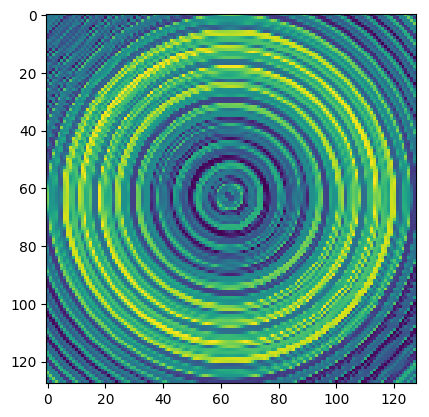

In [6]:
# Plotting the last snapshot
plt.imshow(data[-1, ..., 0])
plt.show()

In [7]:
# Separating the original data into train, control and test sub-datasets
n_samples = data.shape[0]
train_size = int(0.9*n_samples)
ctrl_size = int(0.05*n_samples)
test_size = int(0.05*n_samples)

# Rescaling the data using standard normalization
rescaler = StandardNormalization()
data_norm = rescaler.rescale(map_dict={'input': data})['input']

train_data = data_norm[:train_size, :, :, :]
ctrl_data = data_norm[train_size:train_size+ctrl_size, :, :, :]
test_data = data_norm[train_size+ctrl_size:, :, :, :]

In [8]:
# Instantiating a Pipeline object in order to execute a reshaping and a POD projection in
# the data
n_components = 500
n_variables = train_data.shape[-1]

rom_config = {
               'n_components': n_components
              }


# Instantiating the class Pipeline
pipeline = Pipeline(stages=[('data_preparer', Reshaper()),
                            ('rom', POD(config=rom_config))])

# Executing the workflow shown in the list stages
pipeline.exec(input_data=train_data)

Executing a global pipeline.
Executed operation RESHAPER.
Relative contribution of the mean component: 0.00015937293103932503
Relative Modal Energy 0.9893942858058135
Executed operation POD.


In [9]:
# Plotting the POD modes
pca_modes_ = pipeline.rom.modes
pca_modes = pipeline.data_preparer.prepare_output_data(pca_modes_)

for vv in range(n_variables):
    
    pca_modes = pca_modes[..., vv]
    pca_modes = np.split(pca_modes, n_components, axis=0)

    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 12))

    for ax, (ii, mode) in zip(axs.flat, enumerate(pca_modes)):
        
        ax.imshow(mode[0])
        ax.set_title('Mode {}, Variable {}'.format(ii, vv))
        plt.tight_layout()

In [11]:
# Testing projection and reconstruction
projected_data = pipeline.project_data(data=test_data)
reconstructed_data = pipeline.reconstruct_data(data=projected_data)

Applying the global reconstruction strategy.


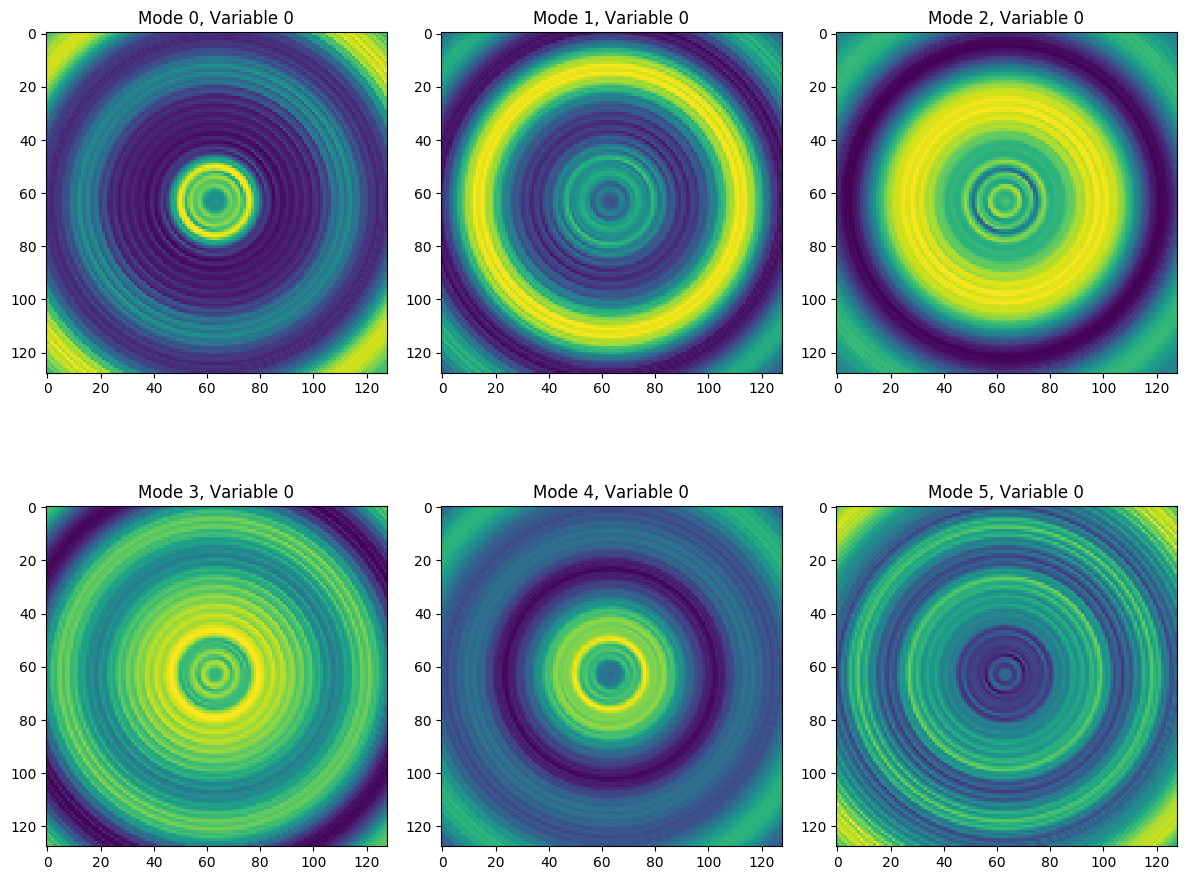

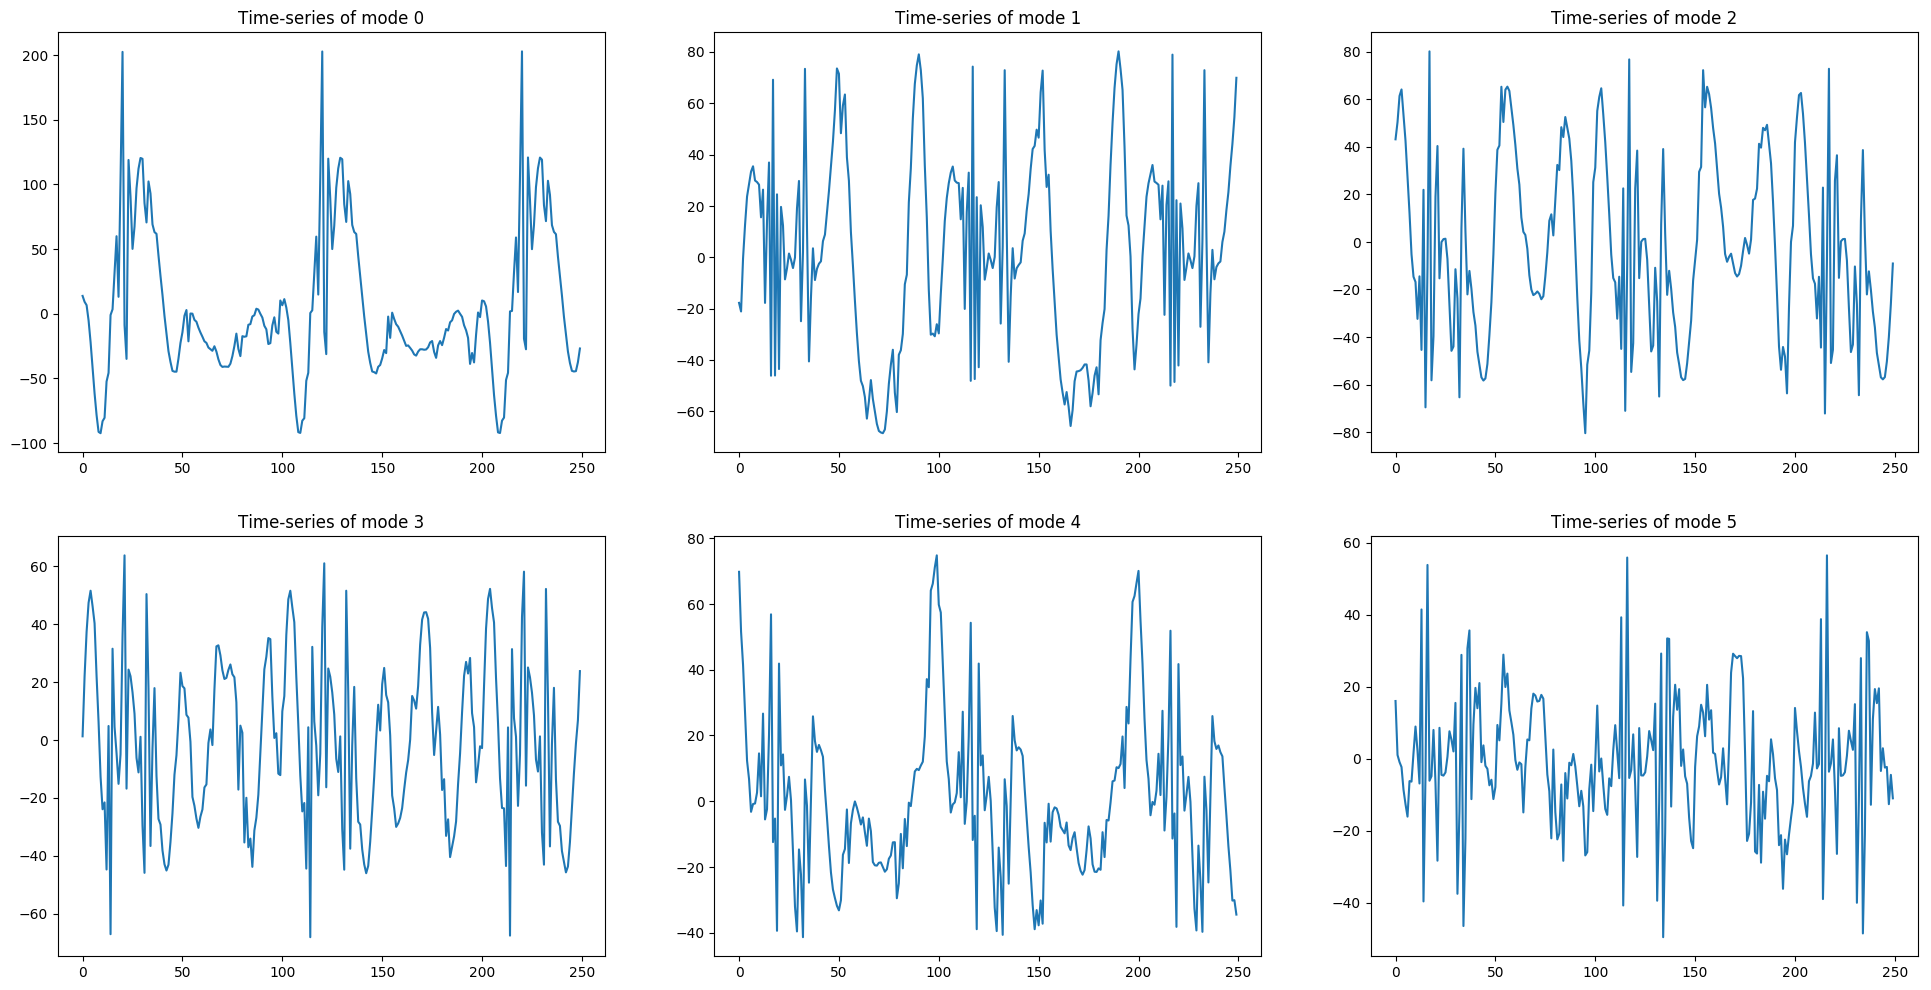

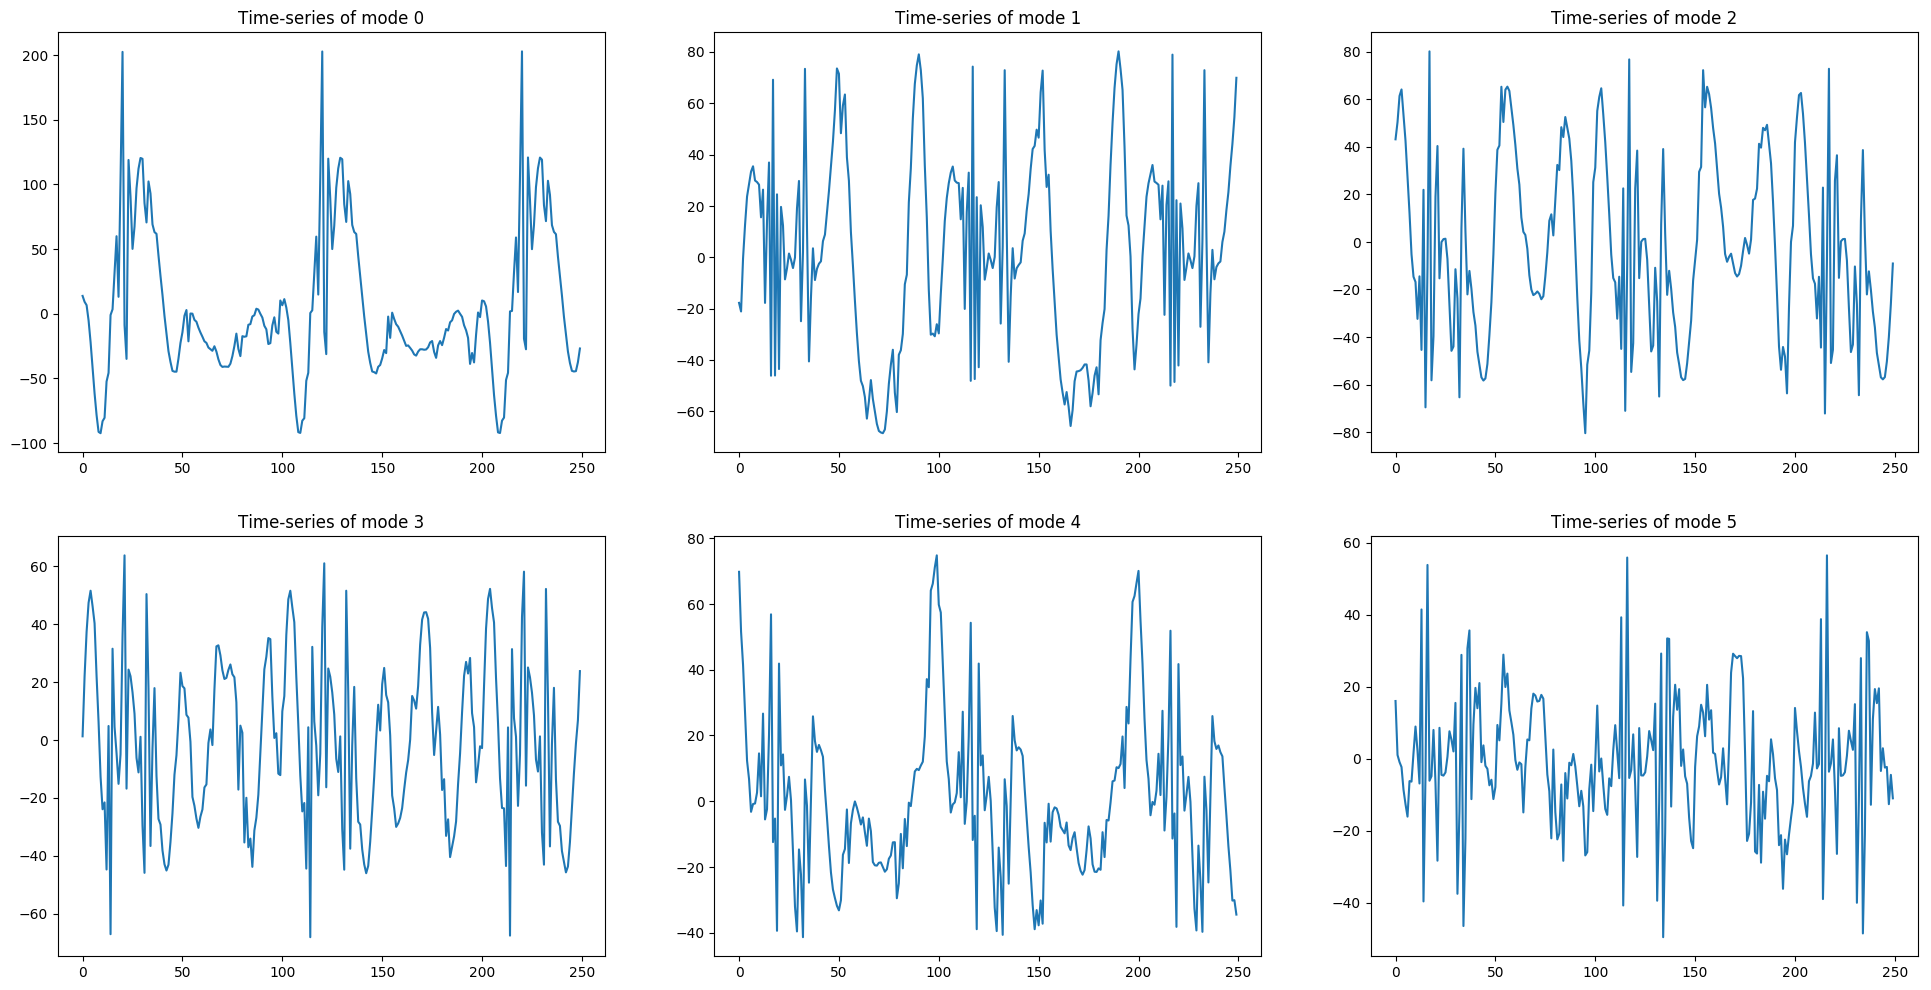

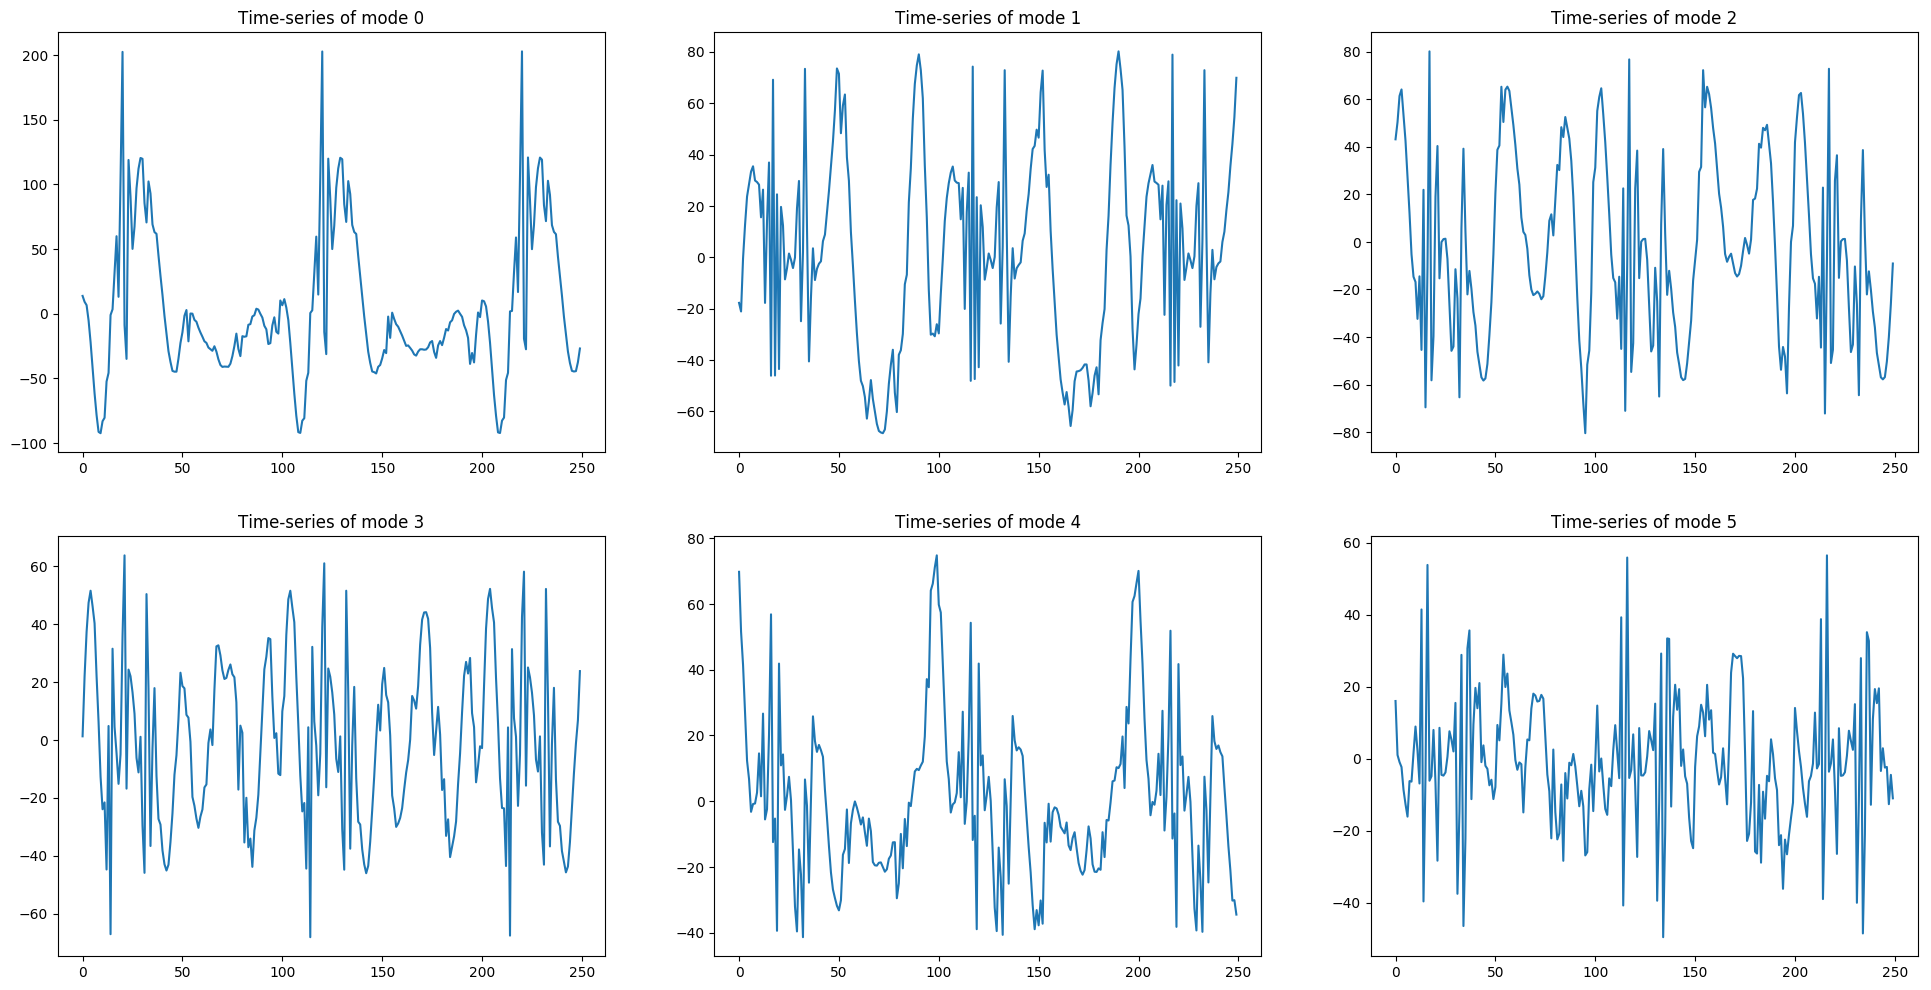

In [14]:
# Plotting the latent space time-series
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))

for ax, ss in zip(axs.flat, range(n_components)):
    ax.plot(projected_data[:, ss])
    ax.set_title('Time-series of mode {}'.format(ss))
plt.show()

In [15]:
# Evaluating the projection error
l2_norm = L2Norm()
error = l2_norm(data=reconstructed_data, reference_data=test_data,
                relative_norm=True)


print('Projection error')
print('{} %'.format(100*error))

Projection error
22.48998114276898 %
